In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [35]:
def histogram_params(model, xscale, abs=True):
    params = torch.cat([x.flatten() for x in model.parameters()]) # compress weights into 1-D

    if abs:
        params = torch.abs(params)

    hist_values, bin_edges = torch.histogram(params, bins=300, range=xscale)
    hist_values = hist_values.detach().numpy()
    bin_edges = bin_edges.detach().numpy()
    width = np.diff(bin_edges)
    return (hist_values, bin_edges, width)

def weights_dist_normal(model_name, model, save=True):
    '''
    plot disitribution of weights on nomal scale
    '''
    hist_values, bin_edges, width = histogram_params(model, (-1,1), abs=False)

    plt.bar(bin_edges[:-1], hist_values, width)
    plt.title(f'{model_name}: Distribution of Weights on Nomal Scale')
    plt.xlabel("Weights")
    plt.ylabel("Counts")
    if save:
        plt.savefig(f"plots/{model_name}_weights_dist_normal.png", dpi=199)
    plt.show()


def weights_dist_log(model_name, model, save=True):
    '''
    plot disitribution of weights on log scale
    '''
    hist_values, bin_edges, width = histogram_params(model, (0,1))

    plt.bar(bin_edges[:-1], hist_values, width)
    plt.xscale('log')
    plt.title(f'{model_name}: Distribution of Weights on Log Scale')
    plt.xlabel("Weights (Log of Absolute Value)")
    plt.ylabel("Counts")
    plt.vlines(x = 1e-2, ymin = 0, ymax = np.max(hist_values), colors = 'red')
    plt.vlines(x = 1e-1, ymin = 0, ymax = np.max(hist_values), colors = 'red')
    if save:
        plt.savefig(f"plots/{model_name}_weights_dist_log.png", dpi=199)
    plt.show()


def sparsity_overall(model):
    '''
    Assess sparsity on overall structure
    '''
    thresholds = [1e-2, 1e-1]
    params = torch.cat([x.flatten() for x in model.parameters()]) # compress weights into 1-D
    abs_params = torch.abs(params).detach().numpy()

    for thresold in thresholds:
        counts = (abs_params < thresold).sum()
        percent = round(counts/len(abs_params)*100, 2)
        print(f'{percent}% of total weights < {thresold}')

    percent = round((len(abs_params)-counts)/len(abs_params)*100, 2)
    print(f'{percent}% of total weights >= {thresholds[-1]}')


def sparsity_layers(model_name, module_list, save=True):
    '''
    Assess sparsity per layer and plot
    '''
    thresholds = [1e-2, 1e-1]
    layers = []

    for idx, layer in enumerate(module_list):
        cur = [idx]

        params = torch.cat([x.flatten() for x in layer.parameters()])
        abs_params = torch.abs(params).detach().numpy()

        counts = 0
        
        for thresold in thresholds:
            counts = (abs_params < thresold).sum()
            percent = round(counts/len(abs_params)*100, 2)
            cur.append(percent)

        percent = round((len(abs_params)-counts)/len(abs_params)*100, 2)
        cur.append(percent)
        layers.append(cur)
        
    df = pd.DataFrame(layers, columns=["layer", "below1e-2", "below1e-1", "above1e-1"])
    df['btw1e-2and1e-1'] = df['below1e-1'] - df['below1e-2']
    df = df.drop(['layer', 'below1e-1'], axis=1)
    df = df[['below1e-2', 'btw1e-2and1e-1', 'above1e-1']]
    ax = df.plot.bar(xlabel="layer", ylabel="percentage", title=f"{model_name}: Distribution of Weights by Layers", stacked=True).legend(['w<0.01', '0.01<=w<0.1', 'w>=0.1'])
    if save:
        plt.savefig(f"plots/{model_name}_weights_by_layers.png", dpi=199)
    plt.show()


## Encoder-Only: RoBERTa

In [16]:
from transformers import RobertaModel
roberta_model = RobertaModel.from_pretrained("roberta-large")

Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


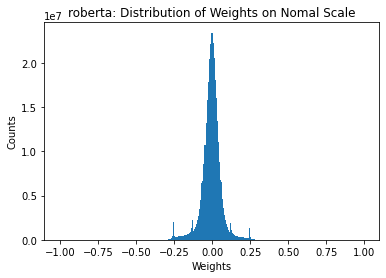

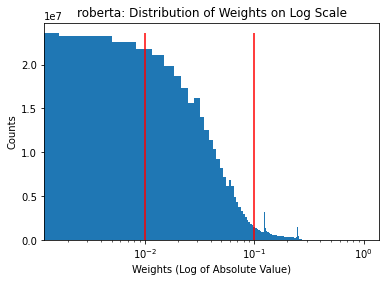

In [36]:
weights_dist_normal("roberta", roberta_model)
weights_dist_log("roberta", roberta_model)

19.53% of total weights < 0.01
90.56% of total weights < 0.1
9.44% of total weights >= 0.1


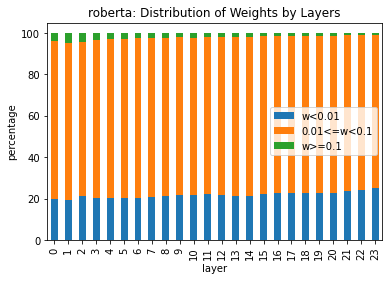

In [29]:
sparsity_overall(roberta_model)
sparsity_layers("roberta", roberta_model.encoder.layer)


## Decoder-Only: GPT-2

In [9]:
from transformers import GPT2Model
gpt2_model = GPT2Model.from_pretrained("gpt2")

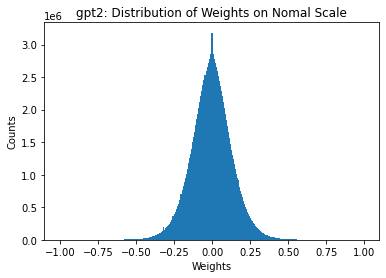

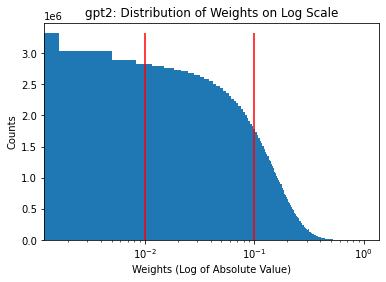

In [37]:
weights_dist_normal("gpt2", gpt2_model)
weights_dist_log("gpt2", gpt2_model)

7.43% of total weights < 0.01
58.78% of total weights < 0.1
41.22% of total weights >= 0.1


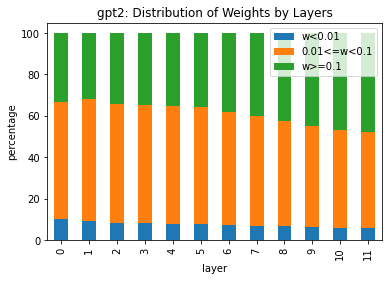

In [30]:
sparsity_overall(gpt2_model)
sparsity_layers("gpt2", gpt2_model.h)

## Encoder-Decoder: BART

In [31]:
from transformers import BartModel
bart_model = BartModel.from_pretrained("facebook/bart-large")

Downloading:   0%|          | 0.00/1.63k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.02G [00:00<?, ?B/s]

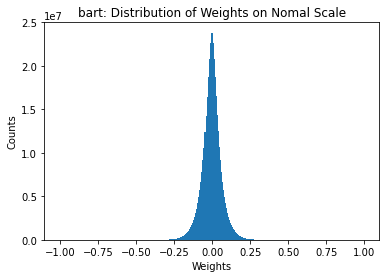

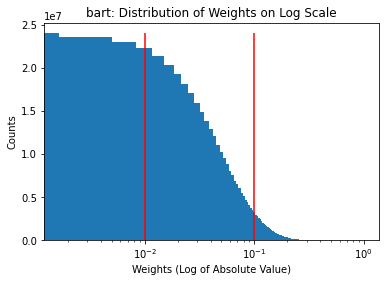

In [38]:
weights_dist_normal("bart", bart_model)
weights_dist_log("bart", bart_model)

17.38% of total weights < 0.01
89.51% of total weights < 0.1
10.49% of total weights >= 0.1


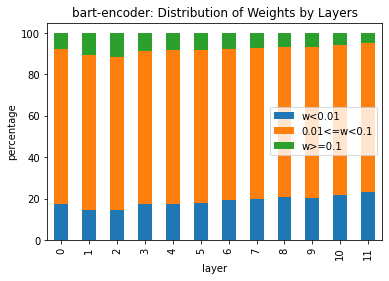

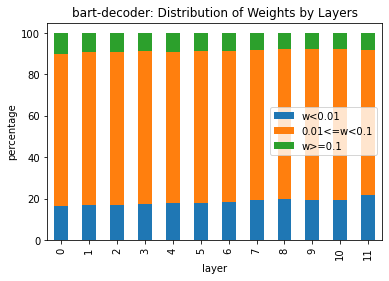

In [39]:
sparsity_overall(bart_model)
sparsity_layers("bart-encoder", bart_model.encoder.layers)
sparsity_layers("bart-decoder", bart_model.decoder.layers)

## Sparsifying GPT-2

In [99]:
from torch.nn.utils import prune

def get_weight_names(layer):
    weight_names = []
    if len(list(layer.children())) > 0:
        for child in layer.children():
            if not list(child.children()): ## leaf node
                for p in child.named_parameters():
                    if 'weight' in p[0]:
                        print(p)
                        weight_names.append((child, p[0]))
            else:
                weight_names.extend(get_weight_names(child))
    
    
    return weight_names

def get_weight_parameters(layer):
    '''
    get all parameters/modules identified as 'weight'
    '''
    weight_parameters = []
    if len(list(layer.children())) > 0:
        for child in layer.children():
            for param in child.named_parameters():
                if 'weight' == param[0]:
                    # print(param)
                    weight_parameters.append((child, param[0]))
            weight_parameters.extend(get_weight_parameters(child))
    
    
    return weight_parameters


def prune_weight_parameters(model, prune_amount):
    '''
    Global Pruning
    '''
    weight_parameters = get_weight_parameters(model)

    prune.global_unstructured(
        weight_parameters, 
        pruning_method=prune.L1Unstructured, 
        amount=prune_amount,
    )

    for module, name in weight_parameters:
        prune.remove(module, name)
    return model
    

In [92]:
print(len(list(model.children())))

print(type(model.children()))

# print(list(model.children()))

i = 0
for c in model.children():
    i+=1
    # print(len(list(c.named_parameters())))
    # print(f"{i}: {c}")
    # if len(list(c.children())) > 0:
    #     print(f"{i} has children")
    for p in c.named_parameters():
        if 'weight' == p[0]:
            print(f"{i} has weight")

# print(i)


5
<class 'generator'>
1 has weight
2 has weight
5 has weight


In [93]:
i = 0
for p in model.named_parameters():
    i+=1
    print(f"{i}: {p[0]}")
    if 'weight' == p[0]:
        print(f"This {i} has pure weight!")

print(i)

1: wte.weight
2: wpe.weight
3: h.0.ln_1.weight
4: h.0.ln_1.bias
5: h.0.attn.c_attn.weight
6: h.0.attn.c_attn.bias
7: h.0.attn.c_proj.weight
8: h.0.attn.c_proj.bias
9: h.0.ln_2.weight
10: h.0.ln_2.bias
11: h.0.mlp.c_fc.weight
12: h.0.mlp.c_fc.bias
13: h.0.mlp.c_proj.weight
14: h.0.mlp.c_proj.bias
15: h.1.ln_1.weight
16: h.1.ln_1.bias
17: h.1.attn.c_attn.weight
18: h.1.attn.c_attn.bias
19: h.1.attn.c_proj.weight
20: h.1.attn.c_proj.bias
21: h.1.ln_2.weight
22: h.1.ln_2.bias
23: h.1.mlp.c_fc.weight
24: h.1.mlp.c_fc.bias
25: h.1.mlp.c_proj.weight
26: h.1.mlp.c_proj.bias
27: h.2.ln_1.weight
28: h.2.ln_1.bias
29: h.2.attn.c_attn.weight
30: h.2.attn.c_attn.bias
31: h.2.attn.c_proj.weight
32: h.2.attn.c_proj.bias
33: h.2.ln_2.weight
34: h.2.ln_2.bias
35: h.2.mlp.c_fc.weight
36: h.2.mlp.c_fc.bias
37: h.2.mlp.c_proj.weight
38: h.2.mlp.c_proj.bias
39: h.3.ln_1.weight
40: h.3.ln_1.bias
41: h.3.attn.c_attn.weight
42: h.3.attn.c_attn.bias
43: h.3.attn.c_proj.weight
44: h.3.attn.c_proj.bias
45: h.3.l

In [82]:
weights = get_weight_names(model)
# print(weights)
print(len(weights))



('weight', Parameter containing:
tensor([[-0.1101, -0.0393,  0.0331,  ..., -0.1364,  0.0151,  0.0453],
        [ 0.0403, -0.0486,  0.0462,  ...,  0.0861,  0.0025,  0.0432],
        [-0.1275,  0.0479,  0.1841,  ...,  0.0899, -0.1297, -0.0879],
        ...,
        [-0.0445, -0.0548,  0.0123,  ...,  0.1044,  0.0978, -0.0695],
        [ 0.1860,  0.0167,  0.0461,  ..., -0.0963,  0.0785, -0.0225],
        [ 0.0514, -0.0277,  0.0499,  ...,  0.0070,  0.1552,  0.1207]],
       requires_grad=True))
('weight', Parameter containing:
tensor([[-1.8821e-02, -1.9742e-01,  4.0267e-03,  ..., -4.3044e-02,
          2.8267e-02,  5.4490e-02],
        [ 2.3959e-02, -5.3792e-02, -9.4879e-02,  ...,  3.4170e-02,
          1.0172e-02, -1.5573e-04],
        [ 4.2161e-03, -8.4764e-02,  5.4515e-02,  ...,  1.9745e-02,
          1.9325e-02, -2.1424e-02],
        ...,
        [-1.7987e-03,  1.6052e-03, -5.5103e-02,  ...,  1.3617e-02,
         -7.1805e-03,  3.7552e-03],
        [ 3.2105e-03,  1.5501e-03, -4.8944e-02,

In [100]:
w2 = get_weight_parameters(model)
print(len(w2))

('weight', Parameter containing:
tensor([[-0.1101, -0.0393,  0.0331,  ..., -0.1364,  0.0151,  0.0453],
        [ 0.0403, -0.0486,  0.0462,  ...,  0.0861,  0.0025,  0.0432],
        [-0.1275,  0.0479,  0.1841,  ...,  0.0899, -0.1297, -0.0879],
        ...,
        [-0.0445, -0.0548,  0.0123,  ...,  0.1044,  0.0978, -0.0695],
        [ 0.1860,  0.0167,  0.0461,  ..., -0.0963,  0.0785, -0.0225],
        [ 0.0514, -0.0277,  0.0499,  ...,  0.0070,  0.1552,  0.1207]],
       requires_grad=True))
('weight', Parameter containing:
tensor([[-1.8821e-02, -1.9742e-01,  4.0267e-03,  ..., -4.3044e-02,
          2.8267e-02,  5.4490e-02],
        [ 2.3959e-02, -5.3792e-02, -9.4879e-02,  ...,  3.4170e-02,
          1.0172e-02, -1.5573e-04],
        [ 4.2161e-03, -8.4764e-02,  5.4515e-02,  ...,  1.9745e-02,
          1.9325e-02, -2.1424e-02],
        ...,
        [-1.7987e-03,  1.6052e-03, -5.5103e-02,  ...,  1.3617e-02,
         -7.1805e-03,  3.7552e-03],
        [ 3.2105e-03,  1.5501e-03, -4.8944e-02,

In [ ]:
from torch.nn.utils import prune

def prune_weights(model, to_prune=0.1):
    def get_weight_names(layer):
        weight_names = []
        if len(list(layer.children())) > 0:
            for child in layer.children():
                if not list(child.children()):
                    for p in child.named_parameters():
                        if 'weight' in p[0]:
                            weight_names.append((child, p[0]))
                else:
                    weight_names.extend(get_weight_names(child))
        
        
        return weight_names
    
    weights = get_weight_names(model)
    
    prune.global_unstructured(weights, pruning_method=prune.L1Unstructured, amount=to_prune)
    
    for layer, name in weights:
        prune.remove(layer, name)
    return model

In [12]:
print(type(gpt2_model.h))

<class 'torch.nn.modules.container.ModuleList'>


In [13]:
print(type(model.encoder.layer))

<class 'torch.nn.modules.container.ModuleList'>
